In [1]:
import numpy as np
from pathlib import Path
import struct
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import time

In [10]:
dataset_path = Path("./MNIST")
train_img_path = dataset_path/'train-images-idx3-ubyte'
train_lab_path = dataset_path/'train-labels-idx1-ubyte'
test_img_path = dataset_path/'t10k-images-idx3-ubyte'
test_lab_path = dataset_path/'t10k-labels-idx1-ubyte'

with open(train_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    tmp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
    train_img = tmp_img[:]
with open(test_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(train_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    tmp_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
    train_lab = tmp_lab[:]
with open(test_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)

# len(train_img)
# FUNCTION: show_image(index)
def show_image(img, index):
    plt.imshow(img[index].reshape(28, 28), cmap='gray')
    plt.pause(1)
    # print("label: {}".format(label[index]))
    return 0
# show_image(train_img, train_lab, 30)
# len(train_lab[np.where(train_lab == 9)])

# train_num = train_img.shape[0]
# test_num = test_img.shape[0]
# print(train_img.shape)
# print(test_img.shape)
# print(train_lab.shape)

train set shape: (784, 60000)
train lab shape: (1, 60000)
test set shape: (784, 10000)
test lab shape: (1, 10000)


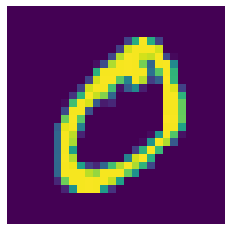

In [14]:
# 将给定num的label改为1
def train_setY(num):
    label = train_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label
def test_setY(num):
    label = test_lab.copy()
    label[np.where(label != num)] = 9
    label[np.where(label == num)] = 1
    label[np.where(label == 9)] = 0
    return label

def reg_num_set(reg_num):
    # reg_num = 6
    train_X = train_img.copy().T
    train_Y = train_setY(reg_num).T
    index_regnum = np.where(train_Y==1)
    # print(index_regnum)
    
    test_X = test_img.copy().T
    test_Y = test_setY(reg_num).T
    print(f"train set shape: {train_X.shape}")
    print(f"train lab shape: {train_Y.shape}")
    print(f"test set shape: {test_X.shape}")
    print(f"test lab shape: {test_Y.shape}")

    # show_image(train_X.T, 1)
    hw0 = train_X.T
    i = index_regnum[1][0]
    np.save(f'handwritten{reg_num}.npy', hw0[i])
    plt.imshow(hw0[i].reshape((28,28)))
    plt.axis('off')

    # # print(train_Y[30])
    # print(train_Y.shape)
    # # print(np.where(train_Y==1))
    # tmp = train_lab.copy().T[:, :limit_train]
    # len(tmp[np.where(tmp == reg_num)])

    return None

reg_num_set(0)

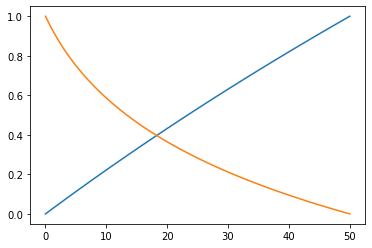

In [9]:
parameters = {
    'a+': 0.02, 'b+': 0.30,
    'a-': 0.05, 'b-': 2.41,
    'wmax': 1, 'wmin': 0
}
weight_plus_list = [parameters['wmin']]
weight_minus_list = [parameters['wmax']]

def weight_plus(w):
    delta_w = parameters['a+'] * np.exp(-parameters['b+']*(w-parameters['wmin'])
                                             /(parameters['wmax']-parameters['wmin']))
    return w+delta_w
def weight_minus(w):
    delta_w = parameters['a-'] * np.exp(-parameters['b-']*(parameters['wmax']-w)
                                             /(parameters['wmax']-parameters['wmin']))
    return w-delta_w
def equation():
    count_num = 0
    while True:
        weight_plus_list.append(weight_plus(weight_plus_list[-1]))
        weight_minus_list.append(weight_minus(weight_minus_list[-1]))
        count_num += 1
        if weight_plus_list[-1] >= 1:
            break
        elif count_num == 50:
            break
        else:
            continue

    # wpl = [0.3*(each - weight_plus_list[0]) / (weight_plus_list[-1]-weight_plus_list[0])-0.2 for each in weight_plus_list]
    # wml = [0.3*(each - weight_minus_list[-1]) / (weight_minus_list[0]-weight_minus_list[-1])-0.2 for each in weight_minus_list]
    
    wpl = [(each - weight_plus_list[0]) / (weight_plus_list[-1]-weight_plus_list[0]) for each in weight_plus_list]
    wml = [(each - weight_minus_list[-1]) / (weight_minus_list[0]-weight_minus_list[-1]) for each in weight_minus_list]
    
    return np.array(wpl), np.array(wml)

GP, GD = equation()
# print(GP)
# print(GD)

# GP_tmp = np.loadtxt("qxs-GP.txt")
# GD_tmp = np.loadtxt("qxs-GD.txt")

# GP = [0.3*(each-min(GP_tmp))/(max(GP_tmp)-min(GP_tmp))-0.2 for each in GP_tmp]
# GD = [0.3*(each-min(GD_tmp))/(max(GD_tmp)-min(GD_tmp))-0.2 for each in GD_tmp]

# GP = [(each-min(GP_tmp))/(max(GP_tmp)-min(GP_tmp)) for each in GP_tmp]
# GD = [(each-min(GD_tmp))/(max(GD_tmp)-min(GD_tmp)) for each in GD_tmp]

plt.plot(GP)
plt.plot(GD)
plt.show()
# np.savetxt(f"GP {parameters['b+']}.txt", GP)
# np.savetxt(f"GD {parameters['b-']}.txt", GD)
# len(GP)

In [15]:
def findGP_num(data, find_array=GP):
    diff = abs(data - find_array)
    index = np.where(diff == np.min(diff))[0][0]
    return find_array[index]

def findGD_num(data, find_array=GD):
    diff = abs(data - find_array)
    index = np.where(diff == np.min(diff))[0][0]
    return find_array[index]

def each_change(matrix_old, gradw):
    matrix_new = matrix_old.copy()
    for i in range(matrix_old.shape[0]):
        if gradw[i] < 0:
            matrix_new[i] = findGP_num(matrix_old[i])
        else:
            matrix_new[i] = findGD_num(matrix_old[i])
    return matrix_new